In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
import math
import time
import lightgbm as lgb
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

tqdm.pandas()

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

- `order_id` : unique id for each order
- `order_time`: time of the creation of order by the client
- `order_date` : date of the order
- `allot_time`: time of allocation of order to the rider
- `accept_time`: time of acceptance of the order by the rider (if available)
- `pickup_time`: time of pickup of the order (if available)
- `delivered_time`: time of delivery of the order (if available)
- `cancelled_time`: time of cancellation of order (if the order was cancelled)
- `cancelled`: whether the order was cancelled
- `rider_id`: unique id for each rider
- `first_mile_distance`: road distance from rider’s location to the pickup location
- `last_mile_distance`: road distance from pickup location to the delivery location
- `allotted_orders`: total number of orders allotted to the rider in the 30 days before (not including) order_date
- `delivered_orders`: total number of orders delivered by the rider in the 30 days before (not including) order_date
- `undelivered_orders`: total number of orders allotted to but not delivered by the rider (i.e. cancelled) in the 30 days before (not including) order_date
- `lifetime_order_count`: total number of orders delivered by the rider at any time before order_date
- `reassigned_order`: whether the order was reassigned to this rider
- `reassignment_method`: if the order was reassigned, whether the reassignment was done manually (by the ops team) or automatically
- `reassignment_reason`: a more detailed reason for the reassignment
- `session_time`: total time the rider had been online on order_date before order_time


In [3]:
id_columns = ['order_id']

time_columns = ['order_time', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time','cancelled_time']

categorical_columns = ['reassignment_method','reassignment_reason']

In [4]:
train.shape

(450000, 20)

In [5]:
train.head(5)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN


## Converting time Columns to datetime format and others to object

In [6]:
for col in time_columns:
    train[col] = pd.to_datetime(train[col])
    try:
        test[col] = pd.to_datetime(test[col])
    except:
        continue

for col in categorical_columns:
    train[col] = train[col].astype('object')
    try:
        test[col] = test[col].astype('object')
    except:
        continue

In [7]:
def log_normal(x):
    if x==0:
        return 0
    if x>0:
        return math.log(x)
    else:
        return math.log(abs(x))

In [8]:
def func(X):
    if X['day'] == 'Saturday' or X['day'] == 'Sunday':
        return 1
    else:
        return 0 

In [9]:
train.isna().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                157
pickup_time               2421
delivered_time            5218
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders           16948
delivered_orders         17341
cancelled                    0
undelivered_orders       17341
lifetime_order_count        53
reassignment_method     436256
reassignment_reason     436247
reassigned_order        436247
session_time              3675
cancelled_time          444782
dtype: int64

In [10]:
absent_cols = []
for i in train.columns:
    if i not in test.columns:
        absent_cols.append(i)
print(absent_cols)

['pickup_time', 'delivered_time', 'cancelled', 'cancelled_time']


In [11]:
def peak_hour(x):
    if x>=8 and x<=11:
        return 1
    if x>=13 and x<=19:
        return 1
    return 0

In [12]:
Y_train = train['cancelled']

In [13]:
def preprocess_df(df):
    df['day'] = df['accept_time'].dt.day_name()
    df['hour'] = df['accept_time'].dt.hour
    df['hour'].fillna(df['hour'].median(),inplace=True)
    df['isWeekend'] = df.apply(func,axis=1)
    df['last_first_mile_ratio'] = df.last_mile_distance / df.first_mile_distance
    df['accept_order_time'] = (df['accept_time']-df['order_time']).dt.total_seconds() / 60.0
    df['accept_allot_time'] = (df['accept_time']-df['allot_time']).dt.total_seconds() / 60.0
    df['total_distance'] = df['first_mile_distance'] + df['last_mile_distance']
    df['session_time'].fillna(0,inplace=True)
    df['delivered_orders'].fillna(0,inplace=True)
    df['lifetime_order_count'].fillna(0,inplace=True)
    df['accept_order_time'].fillna(0,inplace=True)
    df['undelivered_orders'].fillna(0,inplace=True)
    df['accept_allot_time'].fillna(0,inplace=True)
    df['reassigned_order'].fillna(0,inplace=True)
    df['alloted_orders'].fillna(0,inplace=True)
    df['peak_nonpeak_hour'] = df.apply(lambda x : peak_hour(x['hour']),axis=1) 
    df['reliability'] = (df['alloted_orders']-df['undelivered_orders'])*100/df['alloted_orders']
    df['reliability'] = df['reliability'].fillna(0)
    df['avg_sessiontime_per_del'] =  df['session_time'] /  (df['delivered_orders']+1)
    df['avg_distance_per_del'] =  df['total_distance'] /  (df['delivered_orders']+1)

    
    return df

In [14]:
train_df = preprocess_df(train)
test_df = preprocess_df(test)

In [15]:
test_df.shape

(144844, 27)

In [16]:
train_df.shape

(450000, 31)

In [17]:
train_df.drop(absent_cols,axis=1,inplace=True)

In [18]:
train_df.shape

(450000, 27)

In [19]:
train_df.columns

Index(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'rider_id', 'first_mile_distance', 'last_mile_distance',
       'alloted_orders', 'delivered_orders', 'undelivered_orders',
       'lifetime_order_count', 'reassignment_method', 'reassignment_reason',
       'reassigned_order', 'session_time', 'day', 'hour', 'isWeekend',
       'last_first_mile_ratio', 'accept_order_time', 'accept_allot_time',
       'total_distance', 'peak_nonpeak_hour', 'reliability',
       'avg_sessiontime_per_del', 'avg_distance_per_del'],
      dtype='object')

In [20]:
del_cols = ['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'reassignment_method', 'reassignment_reason',
       'day', 'hour']

In [21]:
train_df.drop(del_cols,axis=1,inplace=True)
test_df.drop(del_cols,axis=1,inplace=True)

In [22]:
train_df['cum_sessionTime'] = train_df.session_time / (train_df.groupby('rider_id').cumcount() + 1)
test_df['cum_sessionTime'] = test_df.session_time / (test_df.groupby('rider_id').cumcount() + 1)


train_df['cum_totalDist'] = train_df.total_distance / (train_df.groupby('rider_id').cumcount() + 1)
test_df['cum_totalDist'] = test_df.total_distance / (test_df.groupby('rider_id').cumcount() + 1)

In [23]:
train_df.isna().sum()

rider_id                   0
first_mile_distance        0
last_mile_distance         0
alloted_orders             0
delivered_orders           0
undelivered_orders         0
lifetime_order_count       0
reassigned_order           0
session_time               0
isWeekend                  0
last_first_mile_ratio      0
accept_order_time          0
accept_allot_time          0
total_distance             0
peak_nonpeak_hour          0
reliability                0
avg_sessiontime_per_del    0
avg_distance_per_del       0
cum_sessionTime            0
cum_totalDist              0
dtype: int64

In [24]:
test_df.isna().sum()

rider_id                   0
first_mile_distance        0
last_mile_distance         0
alloted_orders             0
delivered_orders           0
undelivered_orders         0
lifetime_order_count       0
reassigned_order           0
session_time               0
isWeekend                  0
last_first_mile_ratio      0
accept_order_time          0
accept_allot_time          0
total_distance             0
peak_nonpeak_hour          0
reliability                0
avg_sessiontime_per_del    0
avg_distance_per_del       0
cum_sessionTime            0
cum_totalDist              0
dtype: int64

In [25]:
X = train_df.copy()

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [27]:
X['cancel_label'] = Y_train

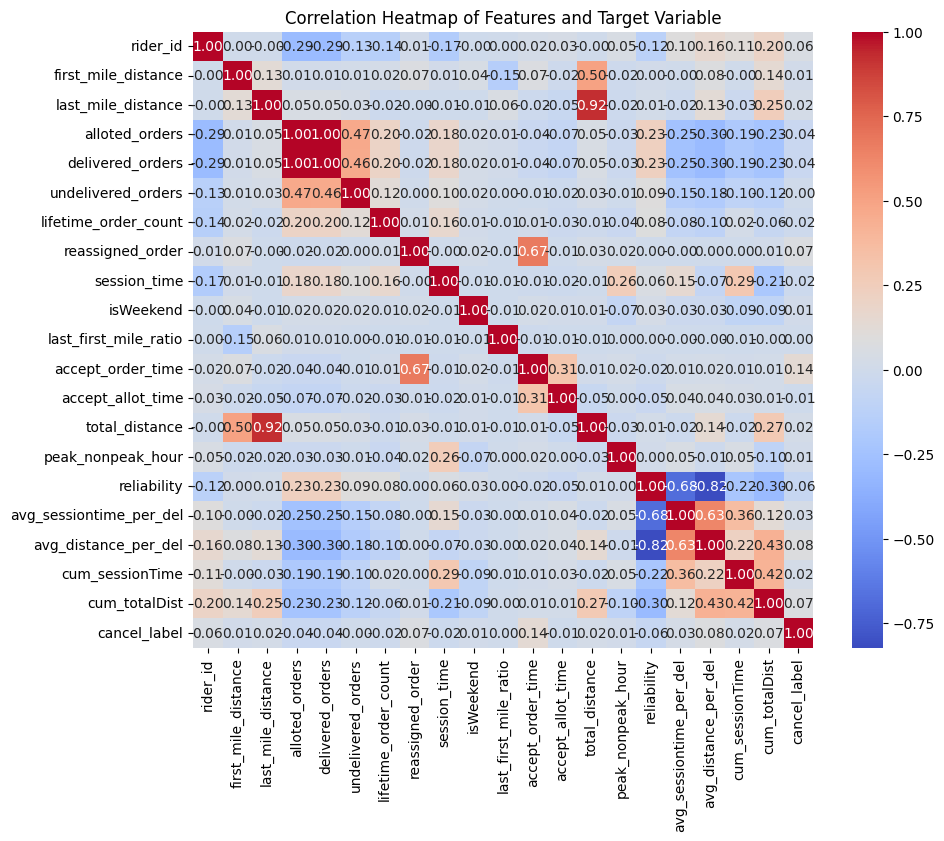

In [28]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features and Target Variable')
plt.show()

In [29]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(train_df, Y_train)

## XGBoost

In [30]:
# Initialize XGBoost classifier
params = {'lambda': 0.20177241158844367, 
          'alpha': 3.4670054832209787, 
          'colsample_bytree': 0.8,
          'subsample': 0.6, 
          'learning_rate': 0.02, 
          'max_depth': 5,
          'random_state': 48, 
          'min_child_weight': 37}

clf = xgb.XGBClassifier(**params)
# Initialize stratified k-fold cross-validation
k_folds = 5  # Number of folds
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation results
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X_sm, y_sm):
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Train XGBoost classifier
    clf.fit(X_train, y_train.values.ravel())
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy and store
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print("accuracy = ",accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

accuracy =  0.726040255630561
accuracy =  0.8572054880756325
accuracy =  0.8625451765750676
accuracy =  0.8560701016789105
accuracy =  0.8702898061963218
Mean Accuracy: 0.8344301656312986


In [31]:
submi = pd.read_csv('sample_submission.csv')
y_pred = clf.predict(test_df)
submi['cancelled'].value_counts()
submi['cancelled'] = y_pred
submi['cancelled'].value_counts()
submi.to_csv('submission_XGB.csv',index=False)
submi.head()

,order_id,cancelled
0,130231,0
1,130232,0
2,130233,0
3,130234,0
4,130235,0


## LightGBM

In [32]:
params = {'lambda': 0.06461544806389825, 
          'alpha': 0.023987779813881015, 
          'colsample_bytree': 0.5, 
          'subsample': 0.7, 
          'learning_rate': 0.009, 
          'max_depth': 9, 
          'random_state': 2020, 
          'min_child_weight': 102}


clf = lgb.LGBMClassifier(**params)
# Initialize stratified k-fold cross-validation
k_folds = 5  # Number of folds
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation results
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X_sm, y_sm):
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Train XGBoost classifier
    clf.fit(X_train, y_train.values.ravel())
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy and store
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print("accuracy = ",accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

[LightGBM] [Warning] lambda_l2 is set with lambda=0.06461544806389825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06461544806389825
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=0.06461544806389825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06461544806389825
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 355826, number of negative: 355825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4594
[LightGBM] [Info] Number of data points in the train set: 711651, number of used features: 20
[LightGBM] [Info]

In [33]:
submi = pd.read_csv('sample_submission.csv')
y_pred = clf.predict(test_df)
submi['cancelled'].value_counts()
submi['cancelled'] = y_pred
submi['cancelled'].value_counts()
submi.to_csv('submission_LGBM.csv',index=False)
submi.head()

[LightGBM] [Warning] lambda_l2 is set with lambda=0.06461544806389825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06461544806389825
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,order_id,cancelled
0,130231,0
1,130232,0
2,130233,0
3,130234,0
4,130235,0
